# Preliminary Analysis

### Basic loading and type definitions

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import pearsonr
from scipy import stats

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_excel('../Taller1/datos.xlsx')

In [4]:
df['pais']  = df['Pais'].astype('category')
df = df.drop('Pais', axis = 1)

In [5]:
df['year'] = pd.to_datetime(df['year'], format = '%Y').dt.to_period('Y')
df.set_index(['year'], inplace= True)

In [6]:
df.columns

Index(['Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais'], dtype='object')

### 2. Change vars to logs

In [7]:
for i in ['Produccion ', 'Reservas', 'PIB', 'Oil Prices']:
    df[f'log_{i.lower().strip()}'] = df[i].apply(np.log)

In [8]:
df.rename({'log_oil prices': 'log_oil_prices'}, inplace = True, axis = 1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 672 entries, 1998 to 2021
Freq: A-DEC
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Produccion      672 non-null    float64 
 1   Reservas        672 non-null    float64 
 2   PIB             672 non-null    float64 
 3   Oil Prices      672 non-null    float64 
 4   pais            672 non-null    category
 5   log_produccion  672 non-null    float64 
 6   log_reservas    672 non-null    float64 
 7   log_pib         672 non-null    float64 
 8   log_oil_prices  672 non-null    float64 
dtypes: category(1), float64(8)
memory usage: 49.2 KB


### 3. Correlations

In [10]:
def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'ρ = {r:.2f}', xy=(.7, 0.1), xycoords=ax.transAxes)

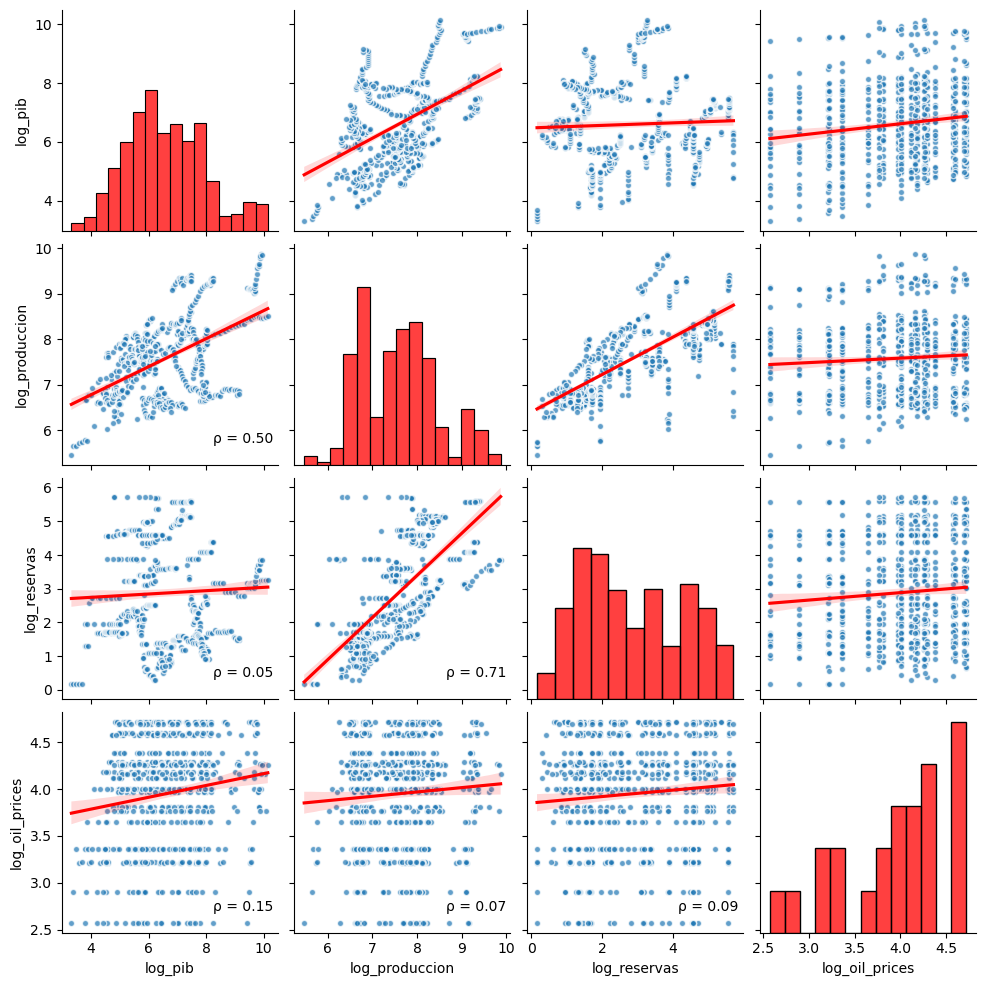

In [11]:
g = sns.pairplot(df[['log_pib', 'log_produccion', 'log_reservas', 'log_oil_prices']], kind = "reg", diag_kind='hist', diag_kws = {'color': 'red'}, plot_kws={'line_kws':{'color':'red'}, 'scatter_kws':{"alpha": 0.7, "s": 20, 'edgecolors': 'white'}})
g.map_lower(corrfunc)
plt.show()

In [14]:
g.savefig('./plots/correlogram_1,1,3.png')

###  3.a  La producción de petroleo se ve afectada fuertemente por las reservas disponibles

### 3.b Ahí están 

### 3.c Más o menos

### 4. Scatter plots

In [27]:
def plot_relations(data: pd.DataFrame, title:str, x:str, y:str):
    fig, ax =plt.subplots(2,2, figsize=(15,8), sharex = False)
    count = 1
    for i in range(len(ax)):
        for j in range(len(ax[i])):
            sns.regplot(data = data, x = x, y = y, scatter_kws={"alpha": 0.7, "s": 20, 'edgecolors': 'white'}, line_kws = {"color": "red"}, ax = ax[i,j], order = count )
            ax[i,j].set_title(f'{title} con ajuste de orden {count}')
            count+=1
    fig.subplots_adjust(wspace=0.3, hspace = 0.3)    
    return fig

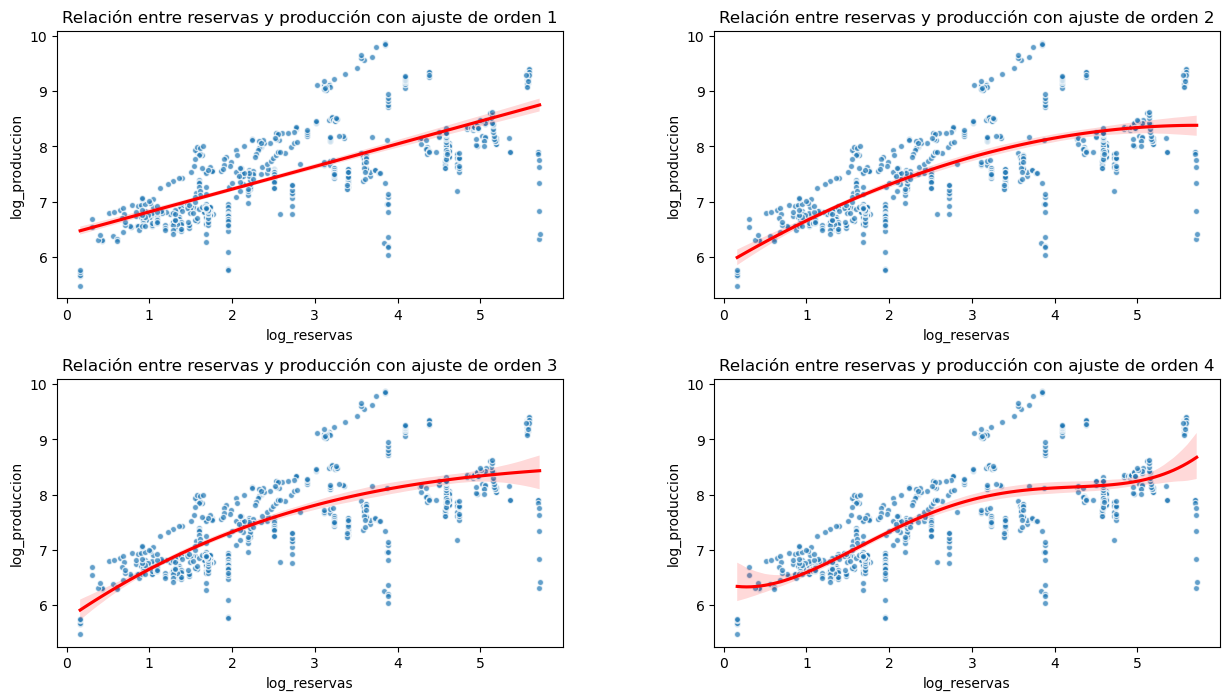

In [32]:
fig = plot_relations(df, 'Relación entre reservas y producción', 'log_reservas', 'log_produccion')

In [33]:
fig.savefig('./plots/scatter_1,1,4,1.png')

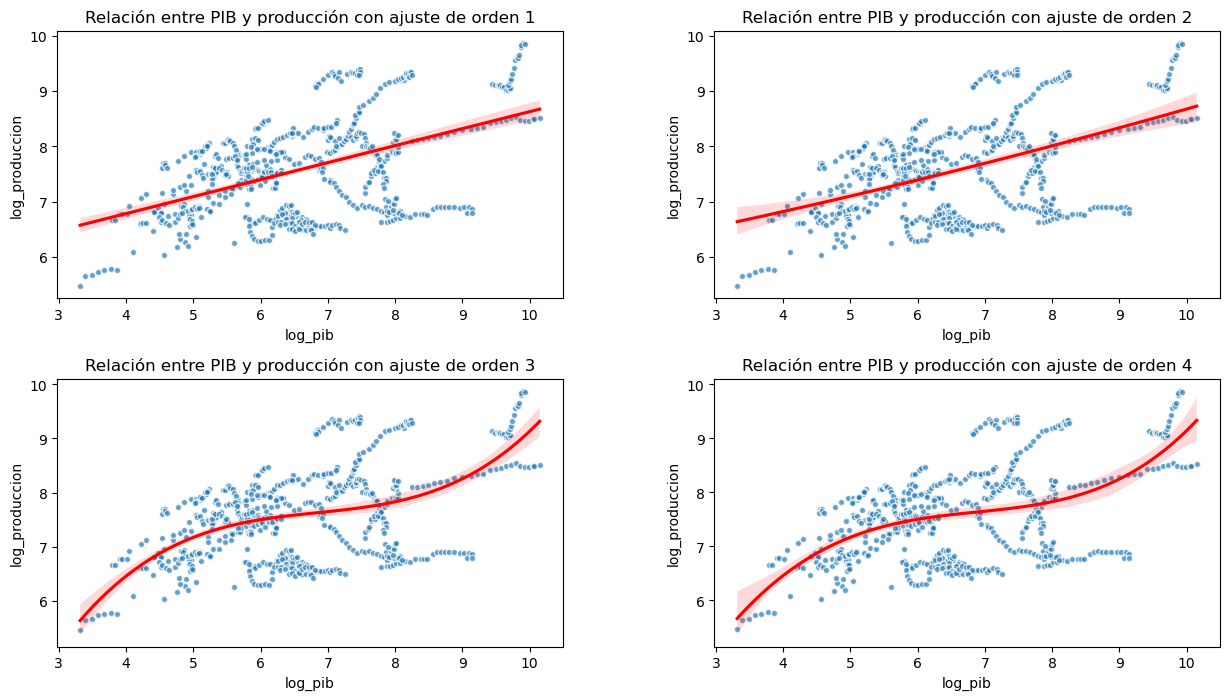

In [34]:
fig = plot_relations(df, 'Relación entre PIB y producción', 'log_pib', 'log_produccion')

In [35]:
fig.savefig('./plots/scatter_1,1,4,2.png')

### 5. Boxplot

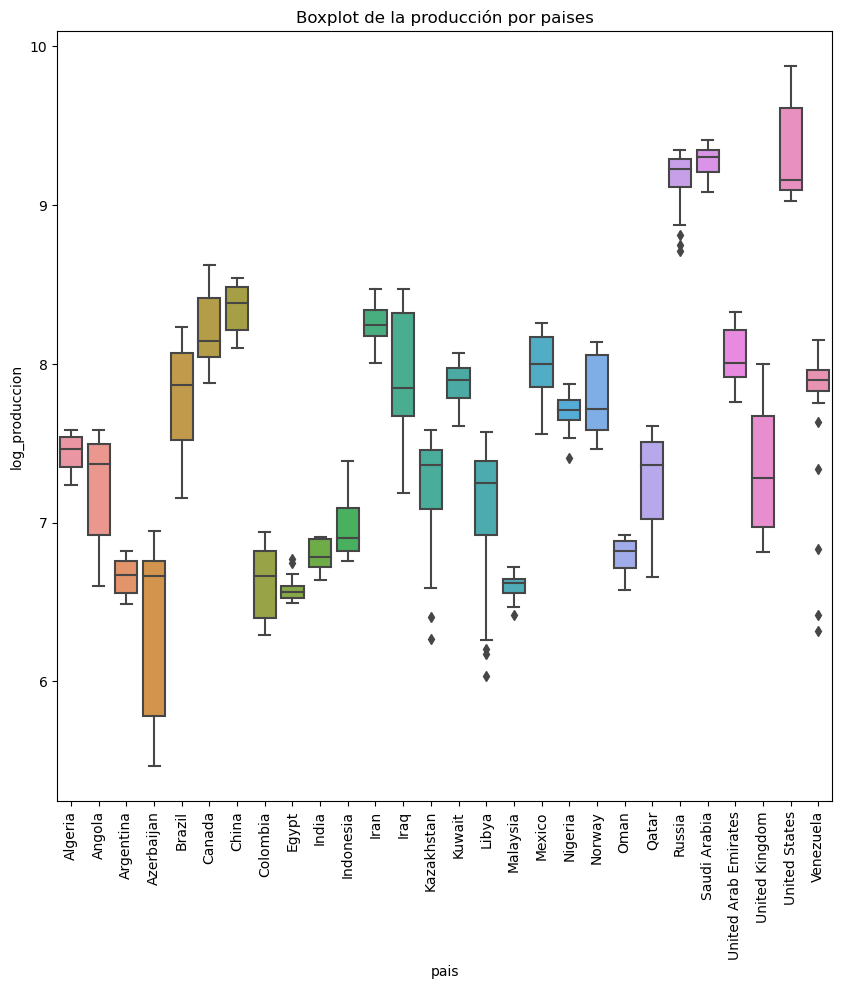

In [38]:
plt.figure(figsize = (10,10))
sns.boxplot(data = df, x = 'pais', y = 'log_produccion')
plt.xticks(rotation = 90)
plt.title('Boxplot de la producción por paises')
plt.show()

In [39]:
box.savefig('./plots/boxplot1,1,5.png')

### 6. Model Estimation
### First Model

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \varepsilon_{it}
$$

In [42]:
df['lag_reserve'] = df.groupby('pais')['log_reservas'].shift(1)

In [45]:
#Verifying we actually lost the first year's observation for all countries
df[df.index == '1998'].head()

,Produccion,Reservas,PIB,Oil Prices,pais,log_produccion,log_reservas,log_pib,log_oil_prices,lag_reserve,lag_resq
year,,,,,,,,,,,
1998,1402.410959,9.2000,259.29310,13.126219,Algeria,7.245948,2.219203,5.557959,2.574612,NaN,NaN
1998,734.582192,5.4120,66.92613,13.126219,Angola,6.599302,1.688619,4.203589,2.574612,NaN,NaN
1998,916.684932,2.5882,627.23620,13.126219,Argentina,6.820764,0.950963,6.441323,2.574612,NaN,NaN
1998,236.773973,1.1780,27.56175,13.126219,Azerbaijan,5.467106,0.163818,3.316429,2.574612,NaN,NaN
1998,1282.627397,4.8000,1890.76100,13.126219,Brazil,7.156666,1.568616,7.544735,2.574612,NaN,NaN


In [46]:
df['lag_resq'] = np.square(df['lag_reserve'])

In [47]:
df.columns

Index(['Produccion ', 'Reservas', 'PIB', 'Oil Prices', 'pais',
       'log_produccion', 'log_reservas', 'log_pib', 'log_oil_prices',
       'lag_reserve', 'lag_resq'],
      dtype='object')

In [48]:
import statsmodels.api as sm

In [49]:
X1 = sm.add_constant(df[['lag_reserve', 'lag_resq', 'log_pib', 'log_oil_prices']])
Y = df["log_produccion"]

model1 = sm.OLS(Y, X1, missing = 'drop').fit() 
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     466.0
Date:                Thu, 02 Mar 2023   Prob (F-statistic):          8.52e-188
Time:                        00:39:02   Log-Likelihood:                -366.10
No. Observations:                 644   AIC:                             742.2
Df Residuals:                     639   BIC:                             764.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              4.5577      0.159     28.

### Second Model

$$
y_{it} = \alpha_0 + \beta_{1}R_{it-1} + \beta_{2}R_{it-1}^{2} + \beta_{3}PIB_{it} + \beta_{4}OIL_{it} + \sum_{j=1}^{27}\gamma_{j}g_{j} +  \varepsilon_{it}
$$

In [50]:
model2= sm.formula.ols('log_produccion ~ C(pais) + lag_reserve + lag_resq  + log_pib + log_oil_prices', data=df).fit()
print(model2.summary()) 

                            OLS Regression Results                            
Dep. Variable:         log_produccion   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     419.1
Date:                Thu, 02 Mar 2023   Prob (F-statistic):               0.00
Time:                        00:39:12   Log-Likelihood:                 192.95
No. Observations:                 644   AIC:                            -321.9
Df Residuals:                     612   BIC:                            -178.9
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

### Aquí iría el análisis

### 7. In sample prediction

In [60]:
predictions = np.exp(model2.predict(df[df.index == '2021']).values)
labels = df[df.index == '2021']['Produccion '].values
errors = predictions - labels

In [62]:
results = pd.DataFrame(data = {'pais': df[df.index=='2021']['pais'], 'produccion':  labels, 'pred_prod': predictions, 'residuals': errors})
results

,pais,produccion,pred_prod,residuals
year,,,,
2021,Algeria,1415.129339,1885.236710,470.107371
2021,Angola,1196.686957,1583.729017,387.042060
2021,Argentina,702.330031,771.184064,68.854032
2021,Azerbaijan,716.735073,912.253896,195.518823
2021,Brazil,3689.416939,2759.453086,-929.963854
2021,Canada,5537.451003,4273.100038,-1264.350965
2021,China,4993.069739,6070.072293,1077.002554
2021,Colombia,764.186095,873.139099,108.953005
2021,Egypt,659.821906,800.743607,140.921701


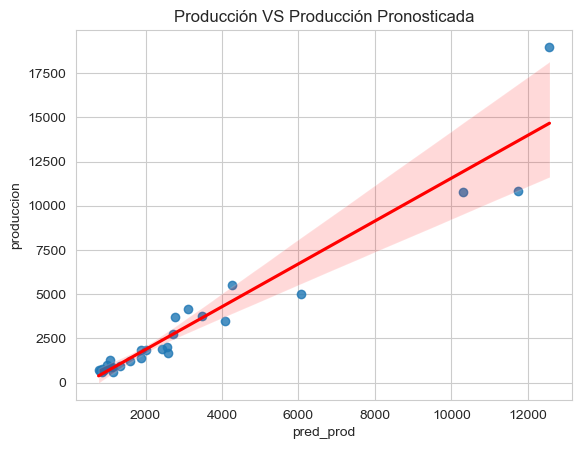

In [72]:
sns.set_style('whitegrid')
sns.regplot(x = results['pred_prod'], y = results['produccion'], line_kws = {'color': 'red'})
plt.title('Producción VS Producción Pronosticada')
plt.savefig('./plots/regplot1,1,6.png')

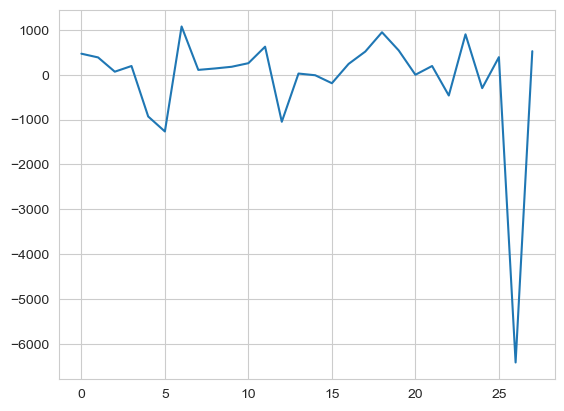

In [73]:
plt.plot(errors)